# Destination Prediction

We want to predict the destination of a driver based on the beginning of its trip. We will use various fractions of the trip from the beginning and see how they allow us to better predict the destination.

In [1]:
%pylab inline
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

import numpy as np
import os
import sys

Populating the interactive namespace from numpy and matplotlib


In [2]:
from src.destination_prediction.utils import *
from src.destination_prediction.model import DestinationLSTM, DestinationLSTMClf
from src.destination_prediction.train import train, evaluate, train_clf, evaluate_clf


### Downloading the dataset
We first download the GeoLife Trajectories dataset from Microsoft.

In [12]:
download_data()

Data has already been downloaded!


### Analyzing the trip length distribution
We first have a look at the data to see what's the distribution of the trip lengths.

Creating a histogram showing the trip length distribution...


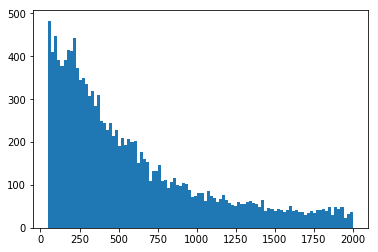

In [4]:
show_trip_length_distribution()

We decide to keep trips of length between 50 and 2000 to train our model. (I already cropped the trips that were shorter or longer than that in the histogram)

### Analyzing GPS position distribution
Let's see where the majority of the trips are concentrated

Creating histograms showing the position distribution...


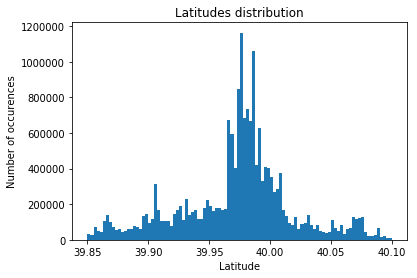

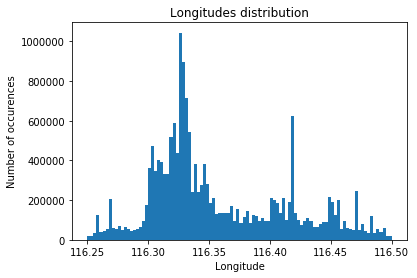

In [3]:
show_position_distribution()

We find that the majority of trips are between longitudes 116.25 and 116.50 and between latitudes 39.85 and 40.10. This is located in Beijing, China. We decide only to keep these values. This will help use reduce the search space in order to make better predictions.

### Splitting the dataset into train, valid, test sets
This creates `train.json`, `valid.json` and `test.json` files containing the datasets. We standardize and randomize the data at the same time.

In [9]:
create_datasets()

Splitting the dataset into train, valid, dev ...
Saving the datasets created...


### Loading the data 

We first load the data from the json files and then we split them in batches to accelerate the LSTM's training. Before splitting into batches, we sort the trips by length so that none of the trips are padded too much.

In [3]:
import json

# loading datasets from json file
with open(os.path.join(os.getcwd(), "geolife_trajectories", "train.json")) as json_data:
    train_dset = json.load(json_data)

with open(os.path.join(os.getcwd(), "geolife_trajectories", "valid.json")) as json_data:    
    valid_dset = json.load(json_data)
    
with open(os.path.join(os.getcwd(), "geolife_trajectories", "test.json")) as json_data:
    test_dset = json.load(json_data)
    
with open(os.path.join(os.getcwd(), "geolife_trajectories", "mean_std.json")) as json_data:
    mean_std_data = json.load(json_data)


In [4]:
#creating batched version of the datasets
batched_train_dset = create_batched_dset(train_dset, batch_size=128)
batched_valid_dset = create_batched_dset(valid_dset, batch_size=1)
batched_test_dset = create_batched_dset(test_dset, batch_size=1)

### Creating our model
We use a LSTM network as our model to predict the destination of the trip. We use this model because the length of trips varies and LSTMs can take inputs of variable lengths. We have two different linear layers to predict both the longitude and the latitude of the destination.

In [7]:
model = DestinationLSTM().to(device)

### Training our model
We train the model using different fractions of the beginning of our trip.

We first sort the trips of each dataset by length so that the training time is reduced a bit

In [8]:
train(model, batched_train_dset, mean_std_data, batched_valid_dset, n_epochs=25, start_lr=1e-4, trip_frac=.5)

Epoch 0 ----- mean distance error : 3.613 ----- mean valid distance error : 4.746
Epoch 1 ----- mean distance error : 3.577 ----- mean valid distance error : 4.720
Epoch 2 ----- mean distance error : 3.551 ----- mean valid distance error : 4.701
Epoch 3 ----- mean distance error : 3.533 ----- mean valid distance error : 4.685
Epoch 4 ----- mean distance error : 3.518 ----- mean valid distance error : 4.670
Epoch 5 ----- mean distance error : 3.504 ----- mean valid distance error : 4.653
Epoch 6 ----- mean distance error : 3.491 ----- mean valid distance error : 4.635
Epoch 7 ----- mean distance error : 3.480 ----- mean valid distance error : 4.618
Epoch 8 ----- mean distance error : 3.473 ----- mean valid distance error : 4.602
Epoch 9 ----- mean distance error : 3.470 ----- mean valid distance error : 4.582
Epoch 10 ----- mean distance error : 3.465 ----- mean valid distance error : 4.564
Epoch 11 ----- mean distance error : 3.457 ----- mean valid distance error : 4.559
Epoch 12 -----

### Show results on the map

Here we show the predicted destination given the beginning of a trip.

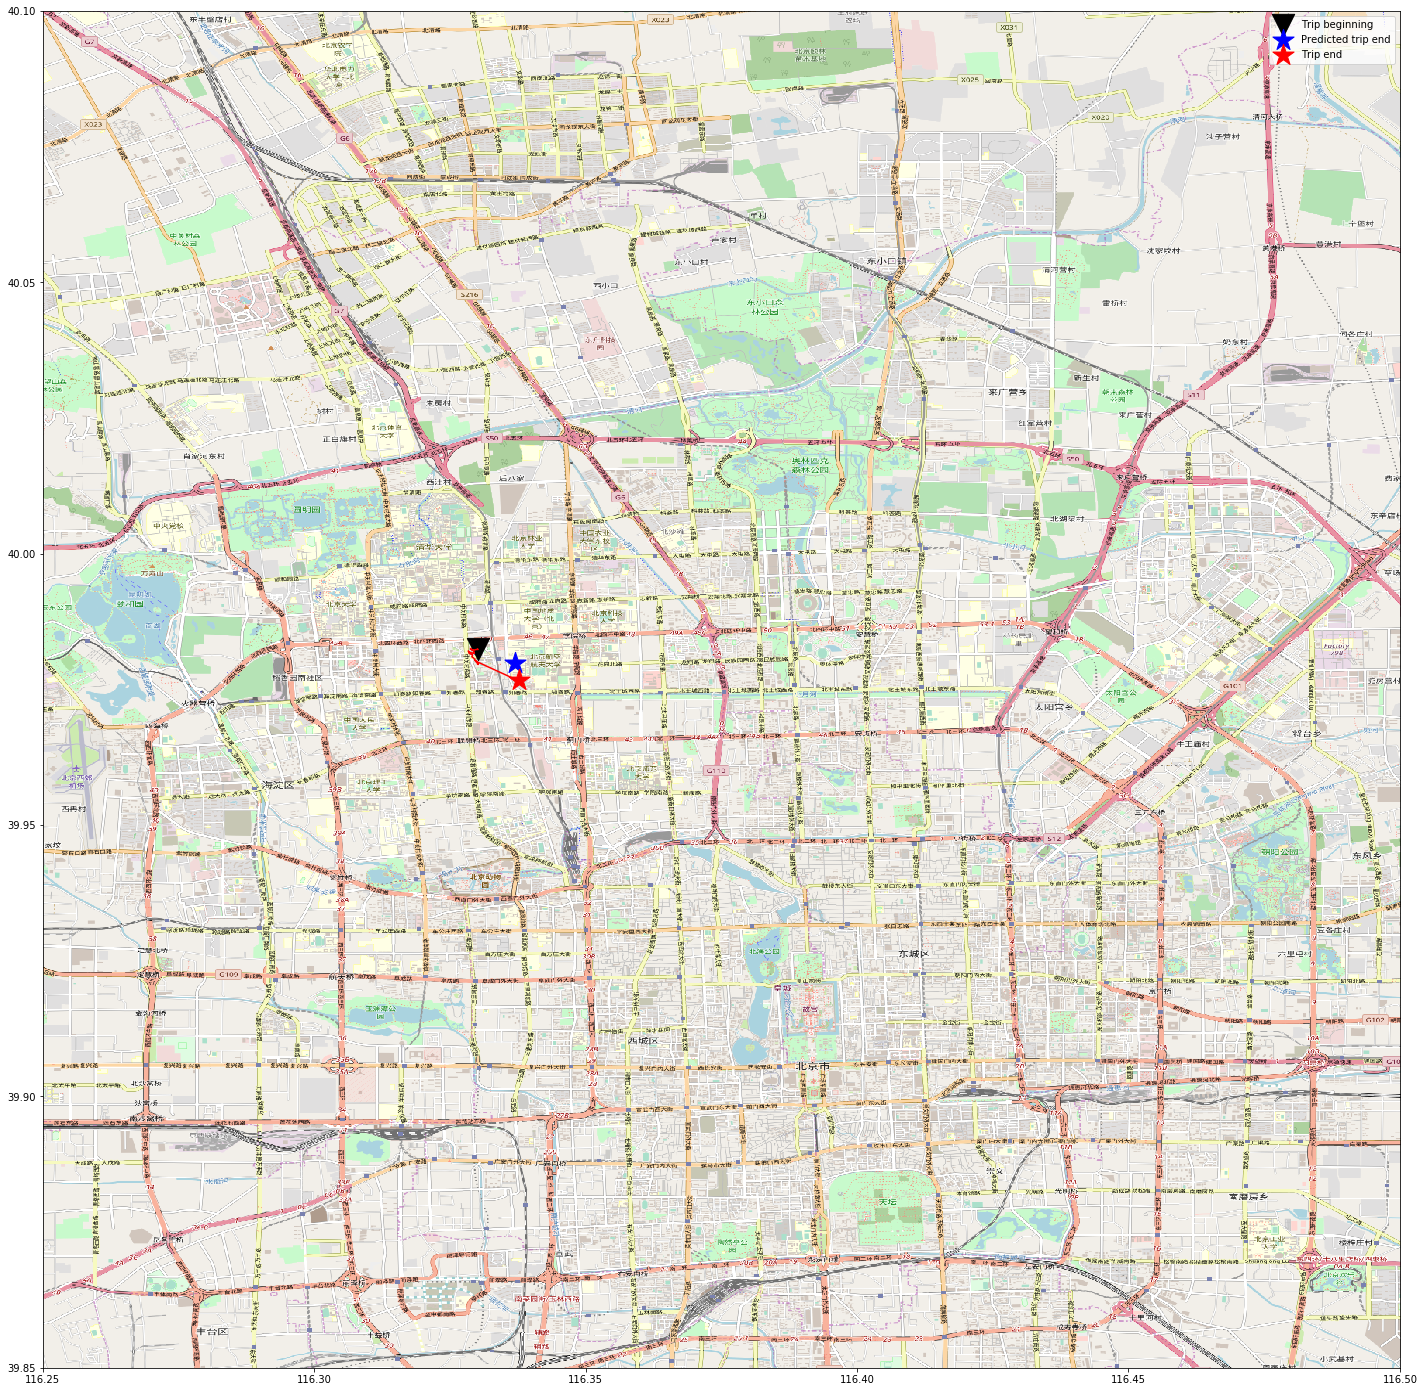

In [9]:
# pick a trip
trip = batched_valid_dset[0]
trajectory = trip[0]
end = trip[1]

# preprocess it
trip_frac = 0.1
inputs = trajectory.to(device)
targets = end.to(device)

# truncate trip to keep only beginning
inputs = inputs[:int(trip_frac*inputs.shape[0])]

# standardize inputs and targets
inputs[:,:,0] = (inputs[:,:,0] - mean_std_data["mean_lat"]) / mean_std_data["std_lat"]
inputs[:,:,1] = (inputs[:,:,1] - mean_std_data["mean_long"]) / mean_std_data["std_long"]

targets[:,0] = (targets[:,0] - mean_std_data["mean_lat"]) / mean_std_data["std_lat"]
targets[:,1] = (targets[:,1] - mean_std_data["mean_long"]) / mean_std_data["std_long"]

# predict output
out_lat, out_long = model(inputs)

# compute mean distance error (km)
# n_pts += inputs.shape[1]

out_lat = out_lat.squeeze().data.to('cpu').numpy()
out_long = out_long.squeeze().data.to('cpu').numpy()
tgt_lat = targets[:,0].squeeze().to('cpu').numpy()
tgt_long = targets[:,1].squeeze().to('cpu').numpy()

# un-standardize data
out_lat = out_lat * mean_std_data["std_lat"] + mean_std_data["mean_lat"]
out_long = out_long * mean_std_data["std_long"] + mean_std_data["mean_long"]
tgt_lat = tgt_lat * mean_std_data["std_lat"] + mean_std_data["mean_lat"]
tgt_long = tgt_long * mean_std_data["std_long"] + mean_std_data["mean_long"]

# print map of Beijing
img=plt.imread('figures/map.png')
plt.figure(figsize = (24.32,31.64))
imgplot = plt.imshow(img, extent=(116.25, 116.5, 39.85, 40.1))

# plot trip, destination and predicted destination

plt.plot(trajectory[:,:,1].numpy(), trajectory[:,:,0].numpy(), 'r')
plt.scatter(trajectory[0,:,1].numpy(), trajectory[0,:,0].numpy(), c='k', marker='v', s=500, label="Trip beginning")
plt.scatter(out_long, out_lat, c='b', marker='*', s=500, label="Predicted trip end")
plt.scatter(tgt_long, tgt_lat, c='r', marker='*', s=500, label="Trip end")

plt.legend(fancybox=True)

plt.show()

## Second try

This time, we use the information we have about the road network to do our prediction. Instead of predicting the (lat, long) of the destination, we try to predict the node (intersection) where the trip will end.

In [10]:
import osmnx as ox

In [ ]:
# instead of doing a regression on the longitudes and latitudes, do a classification on the nearest destination nodes

north, south, east, west = (40.10, 39.85, 116.50, 116.25)
G = ox.graph_from_bbox(north, south, east, west, network_type='all')

In [ ]:
import networkx as nx

# creating mapping to have nodes labeled from 0 to nb_of_nodes
mapping = {}
for i, node in enumerate(G.nodes):
    mapping[node] = i

# creating new graph with said mapping
H = nx.relabel_nodes(G, mapping)


In [ ]:
model = DestinationLSTMClf(graph=H).to(device)

In [86]:
train_clf(model, batched_train_dset, mean_std_data, batched_valid_dset, n_epochs=25, start_lr=1e-2, trip_frac=.5)

Epoch 0 ----- mean distance error : 4.260 ----- mean valid distance error : 4.842
Epoch 1 ----- mean distance error : 3.887 ----- mean valid distance error : 5.439
Epoch 2 ----- mean distance error : 3.628 ----- mean valid distance error : 4.842
Epoch 3 ----- mean distance error : 3.622 ----- mean valid distance error : 5.074
Epoch 4 ----- mean distance error : 3.504 ----- mean valid distance error : 4.503
Epoch 5 ----- mean distance error : 3.436 ----- mean valid distance error : 4.570
Epoch 6 ----- mean distance error : 3.397 ----- mean valid distance error : 4.339
Epoch 7 ----- mean distance error : 3.441 ----- mean valid distance error : 3.827
Epoch 8 ----- mean distance error : 2.980 ----- mean valid distance error : 3.680
Epoch 9 ----- mean distance error : 2.869 ----- mean valid distance error : 3.334
Epoch 10 ----- mean distance error : 3.145 ----- mean valid distance error : 4.300
Epoch 11 ----- mean distance error : 2.878 ----- mean valid distance error : 3.394
Epoch 12 -----

[[40.05633  40.0562   40.056084 ... 39.9794   39.979374 39.979355]]


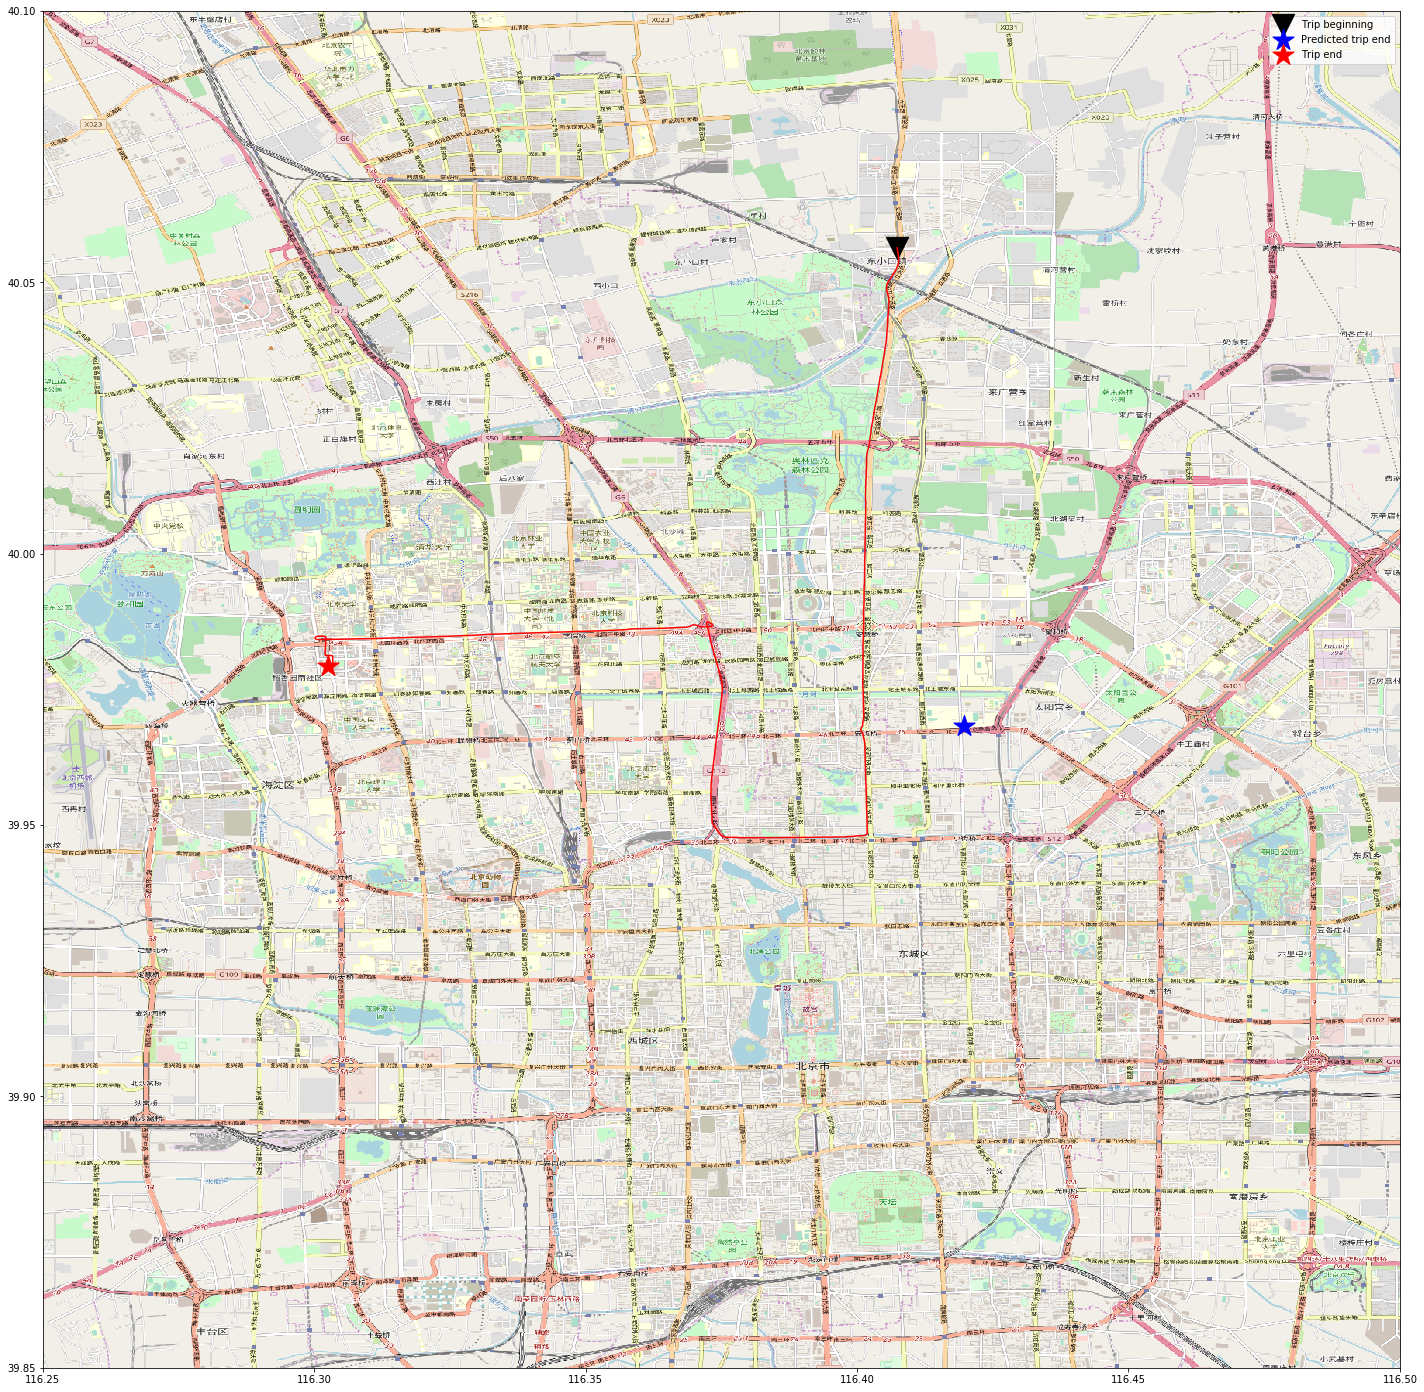

In [88]:
# pick a trip
trip = batched_valid_dset[-3]
trajectory = trip[0]
end = trip[1]

# preprocess it
trip_frac = .5
inputs = trajectory.to(device)
targets = end.to(device)

# truncate trip to keep only beginning
inputs = inputs[:int(trip_frac*inputs.shape[0])]

# standardize inputs and targets
inputs[:,:,0] = (inputs[:,:,0] - mean_std_data["mean_lat"]) / mean_std_data["std_lat"]
inputs[:,:,1] = (inputs[:,:,1] - mean_std_data["mean_long"]) / mean_std_data["std_long"]

# predict output
output = model(inputs)

# compute mean distance error (km)
# n_pts += inputs.shape[1]

predicted_nodes = torch.argmax(output, dim=1).to('cpu').numpy()

out_long = np.zeros(len(targets))
out_lat = np.zeros(len(targets))
for i in range(len(predicted_nodes)):
    out_long[i] = model.graph.node[predicted_nodes[i]]['x']
    out_lat[i] = model.graph.node[predicted_nodes[i]]['y']

tgt_lat = targets[:,0].squeeze().to('cpu').numpy()
tgt_long = targets[:,1].squeeze().to('cpu').numpy()

# print map of Beijing
img=plt.imread('figures/map.png')
plt.figure(figsize = (24.32,31.64))
imgplot = plt.imshow(img, extent=(116.25, 116.5, 39.85, 40.1))

# plot trip, destination and predicted destination

print(trajectory[:,:,0].numpy().T)

plt.plot(trajectory[:,:,1].numpy(), trajectory[:,:,0].numpy(), 'r')
plt.scatter(trajectory[0,:,1].numpy(), trajectory[0,:,0].numpy(), c='k', marker='v', s=500, label="Trip beginning")
plt.scatter(out_long, out_lat, c='b', marker='*', s=500, label="Predicted trip end")
plt.scatter(tgt_long, tgt_lat, c='r', marker='*', s=500, label="Trip end")

plt.legend(fancybox=True)

plt.show()

